In [23]:
import pandas as pd
from IPython.display import Image
import re

In [24]:
pd.options.display.max_rows = 300
pd.options.mode.chained_assignment = None
pd.options.plotting.backend = "plotly"

# Analyse Reference Corpus

The Hathitrust dataset does not comprise all volumes listed in the catalogue. This means that the worksets we create for Named Entity Recognition are smaller than the lists of volumes we have created for NER. In this notebook we parse the sets of "valid volumes" in order to know more about the temporal distribution of the reference corpus.

In [25]:
valid_ger = pd.read_csv("validation/valid_volumes_ger.csv")
valid_fren = pd.read_csv("validation/valid_volumes_fren.csv")
valid_eng = pd.read_csv("validation/valid_volumes_eng.csv")

In [26]:
corp_length = {}
corp_length["German"] = len(valid_ger)
corp_length["French"] = len(valid_fren)
corp_length["English"] = len(valid_eng)
corp_length["Total"] = len(valid_ger) + len(valid_fren) + len(valid_eng)
corp_length_df = pd.DataFrame.from_dict(corp_length, orient="index")
corp_length_df.columns = ["n volumes"]
display(corp_length_df)

n volumes
German         695
French         405
English       1081
Total         2181

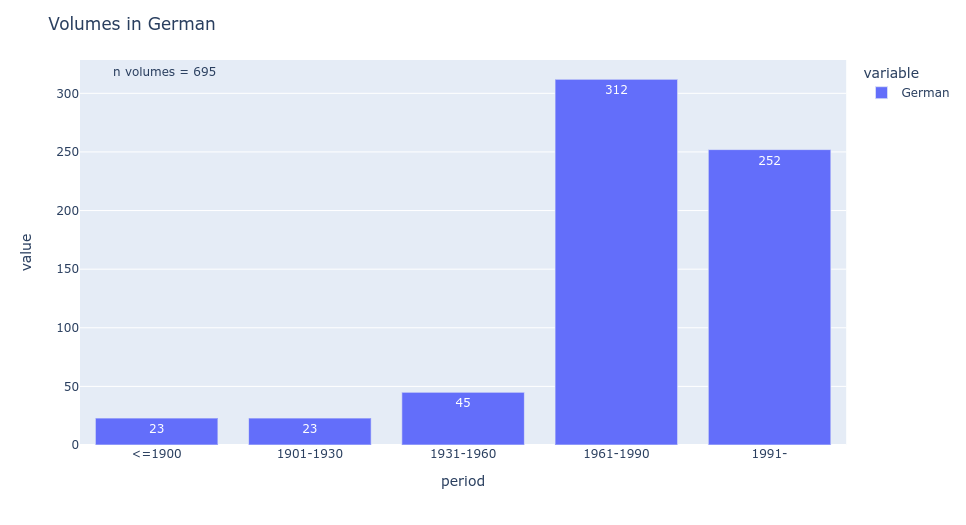

In [27]:
def plot_corpus(df, lang):
    """
    Takes a file with metadata and plots books per period as bar chart.
    Requires Plotly >= 5.6!
    """
    corpus_dict = {}
    corpus_dict["<=1900"] = len(df[df["year"] <= 1900])
    corpus_dict["1901-1930"] = len(df[(df["year"] > 1900) &
                                      (df["year"] <= 1930)])
    corpus_dict["1931-1960"] = len(df[(df["year"] > 1931) &
                                      (df["year"] <= 1960)])
    corpus_dict["1961-1990"] = len(df[(df["year"] > 1961) &
                                      (df["year"] <= 1990)])
    corpus_dict["1991-"] = len(df[df["year"] > 1991])
    result = pd.DataFrame.from_dict(corpus_dict, orient="index")
    result.columns = [lang]
    result.index = result.index.rename("period")
    plot = result.plot.bar(text_auto = True)
    return(plot)
  

plot_corpus_ger = plot_corpus(valid_ger, "German")
n_books = len(valid_ger)
plot_corpus_ger.add_annotation(x=0.05, y=310,
            text=f"n volumes = {n_books}",
            showarrow=False,
            yshift=10)
plot_corpus_ger.update_layout(title={
        'text': "Volumes in German"})

# We display static charts instead of plotly animations. Saving them is brittle, so we do it by hand.

# Uncomment this line when actually running the notebook.
#display(plot_corpus_ger)

# Comment this line when actually running the notebook.
Image("figures/ref_corp_ger.png")

Compared to the French and English corpus the German corpus contains more titles published before 1960. The number of titles published after 1990 decreases.

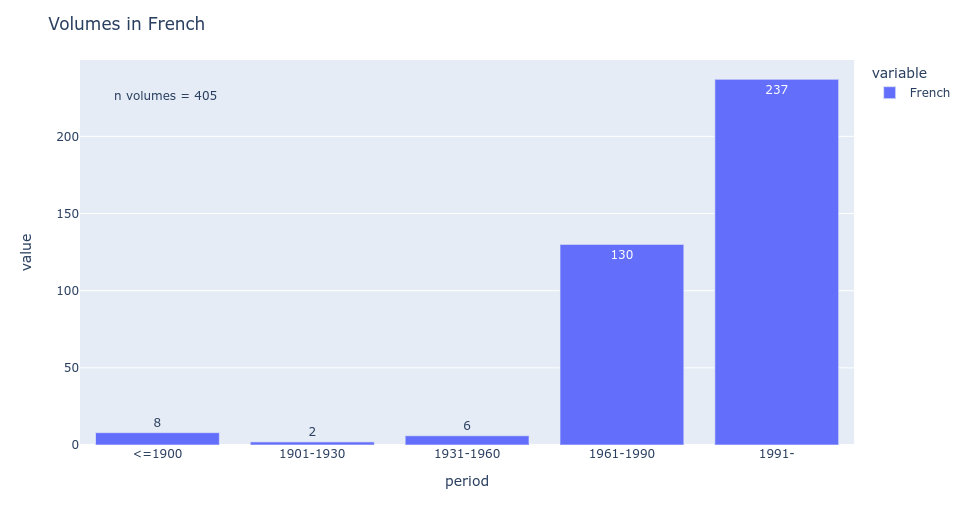

In [28]:
plot_corpus_fren = plot_corpus(valid_fren, "French")
n_books = len(valid_fren)
plot_corpus_fren.add_annotation(x=0.05, y=220,
            text=f"n volumes = {n_books}",
            showarrow=False,
            yshift=10)
plot_corpus_fren.update_layout(title={
        'text': "Volumes in French"})
# Uncomment this line when actually running the notebook.
#display(plot_corpus_fren)

# Comment this line when actually running the notebook.
Image("figures/ref_corp_fren.png")

Most of the titles contained in the French reference corpus were published after 1990.

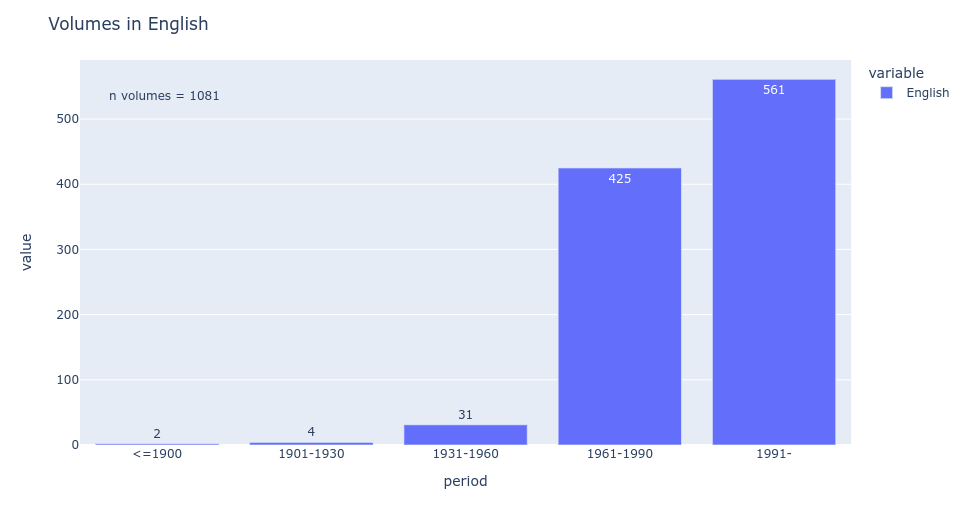

In [29]:
plot_corpus_eng = plot_corpus(valid_eng, "English")
n_books = len(valid_eng)
plot_corpus_eng.add_annotation(x=0.05, y=520,
            text=f"n volumes = {n_books}",
            showarrow=False,
            yshift=10)
plot_corpus_eng.update_layout(title={
        'text': "Volumes in English"})
# Uncomment this line when actually running the notebook.
#display(plot_corpus_eng)

# Comment this line when actually running the notebook.
Image("figures/ref_corp_eng.png")

It seems that before 1960 German scholarly literature in the history of ideas was more relevant in the US than literature in the English language. This changed apparently only after 1990.

## Genres

In [30]:
tmp_ger = pd.read_csv("output/csv/vols_list_ger.csv")
tmp_fren = pd.read_csv("output/csv/vols_list_fren.csv")
tmp_eng = pd.read_csv("output/csv/vols_list_eng.csv")

valid_ger_full = valid_ger.merge(tmp_ger, left_on = "id", right_on = "htid")
valid_fren_full = valid_fren.merge(tmp_fren, left_on = "id", right_on = "htid")
valid_eng_full = valid_eng.merge(tmp_eng, left_on = "id", right_on = "htid")

In [31]:
re_lit = re.compile(r"""literature|fiction|criticism|drama|poetry|goethe|
                    gottsched|stilling|la roche|lessing|fontenelle|novel|
                    schiller|heinse|hippel""", re.VERBOSE)
re_phil = re.compile(r"""philosophy|aesthetics|fichte|kant|knowledge|newton|
                    schopenhauer|locke|mandeville|châtelet|montesquieu|
                    anthropology""", re.VERBOSE)

In [32]:
def read_marc_subs(marc_path):
    """
    Reads MARC metadata from previous step and divides them into 3 subcorpora:
    Literature, philosophy, and "other" (mainly history)
    """
    marc = pd.read_csv(marc_path).drop(columns =["Unnamed: 0"])
    marc["subjects_lower"] = marc["subjects"].str.lower()
    lit_marc = marc[marc["subjects_lower"].str.contains(re_lit)]
    phil_marc = marc[marc["subjects_lower"].str.contains(re_phil)]
    oth_marc = marc.merge(lit_marc, how = "left", indicator = True)
    oth_marc = oth_marc[oth_marc["_merge"] == "left_only"].drop(columns = "_merge")
    oth_marc = oth_marc.merge(phil_marc, how = "left", indicator = True)
    oth_marc = oth_marc[oth_marc["_merge"] == "left_only"]
    return({"lit": lit_marc, "phil": phil_marc, "oth": oth_marc})

ger_marcs_dict = read_marc_subs("output/csv/marc_ger_final.csv")
fren_marcs_dict = read_marc_subs("output/csv/marc_fren_final.csv")
eng_marcs_dict = read_marc_subs("output/csv/marc_eng_final.csv")

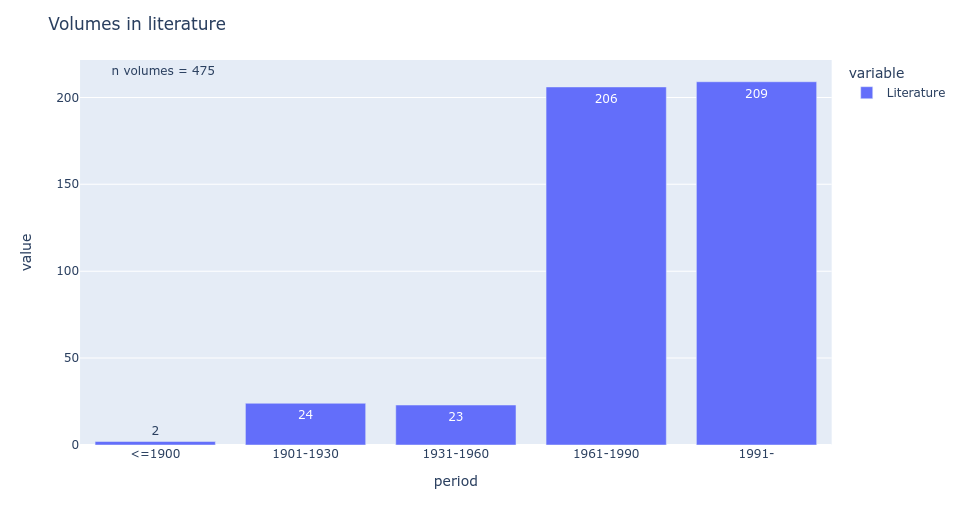

In [45]:
def subcorp_vols(df_marc, df_vols):
    """
    Create volume list for subcorpus.
    """
    df_1 = df_vols.merge(df_marc, left_on = "fromRecord", 
                         right_on = "record_id")
    df_2 = df_1[["record_id_x", "htid", "author_x", "title_y", "pubyear_x", "subjects_x", "lang_x",
                 "ldr_x", "marc_008_x", "len_subs_x", "subj_clean_x", "len_subj_clean_x", "enumcron_clean"]]
    df_2.columns = ["record_id", "htid", "author", "title", "pubyear", "subjects", "lang",
                        "ldr", "marc_008", "len_subs", "subj_clean", "len_subj_clean",
                       "enumcron_clean"]
    
    # For disciplinary canons we remove periodicals, because they are interdisciplinary.
    
    df_3 = df_2[df_2["ldr"] != "s"]
    
    # Criterion for duplicate volumes: same author, title, year, and absence of volumes.
    # Different editions count as different works.
    
    df_4 = df_3.drop_duplicates(subset = ["author", "title",
                                          "pubyear", "enumcron_clean"])
    return(df_4)

vols_ger_lit = subcorp_vols(ger_marcs_dict["lit"], valid_ger_full)
vols_fren_lit = subcorp_vols(fren_marcs_dict["lit"], valid_fren_full)
vols_eng_lit = subcorp_vols(eng_marcs_dict["lit"], valid_eng_full)

lit_pd = pd.concat([vols_ger_lit, vols_fren_lit, vols_eng_lit])
lit_pd["year"] = lit_pd["marc_008"].str[7:11].astype(int)
plot_lit = plot_corpus(lit_pd, "Literature")
n_books = len(lit_pd)
plot_lit.add_annotation(x=0.05, y=210,
            text=f"n volumes = {n_books}",
            showarrow=False,
            yshift=10)
plot_lit.update_layout(title={
        'text': "Volumes in literature"})

# Uncomment this line if you run the notebook
# display(plot_lit)

# Comment this line if you run the notebook

Image("figures/vols_lit.png")

In [35]:
vols_ger_lit.to_csv("output/csv/vols_ger_lit.csv")
vols_fren_lit.to_csv("output/csv/vols_fren_lit.csv")
vols_eng_lit.to_csv("output/csv/vols_eng_lit.csv")

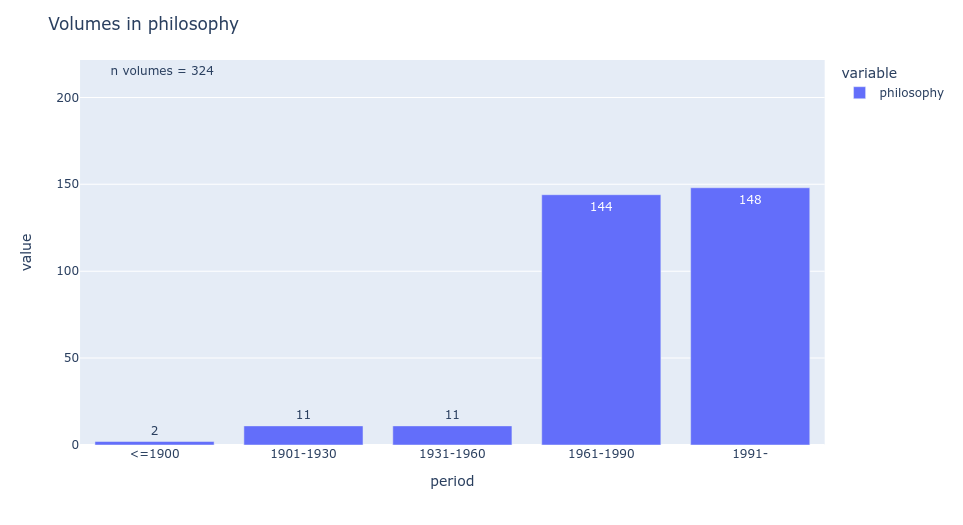

In [46]:
# one title without year of publication

vols_ger_phil = subcorp_vols(ger_marcs_dict["phil"], valid_ger_full)
vols_fren_phil = subcorp_vols(fren_marcs_dict["phil"], valid_fren_full)
vols_eng_phil = subcorp_vols(eng_marcs_dict["phil"], valid_eng_full)

phil_pd = pd.concat([vols_ger_phil, vols_fren_phil, vols_eng_phil])
phil_pd = phil_pd[phil_pd["pubyear"] != "n.d."]
phil_pd["year"] = phil_pd["marc_008"].str[7:11].astype(int)
plot_phil = plot_corpus(phil_pd, "philosophy")
n_books = len(phil_pd)
plot_phil.add_annotation(x=0.05, y=210,
            text=f"n volumes = {n_books}",
            showarrow=False,
            yshift=10)
plot_phil.update_layout(title={
        'text': "Volumes in philosophy"})

# Uncomment this line if you run the notebook
# display(plot_phil)

# Comment this line if you run the notebook

Image("figures/vols_phil.png")

In [42]:
vols_ger_phil.to_csv("output/csv/vols_ger_phil.csv")
vols_fren_phil.to_csv("output/csv/vols_fren_phil.csv")
vols_eng_phil.to_csv("output/csv/vols_eng_phil.csv")

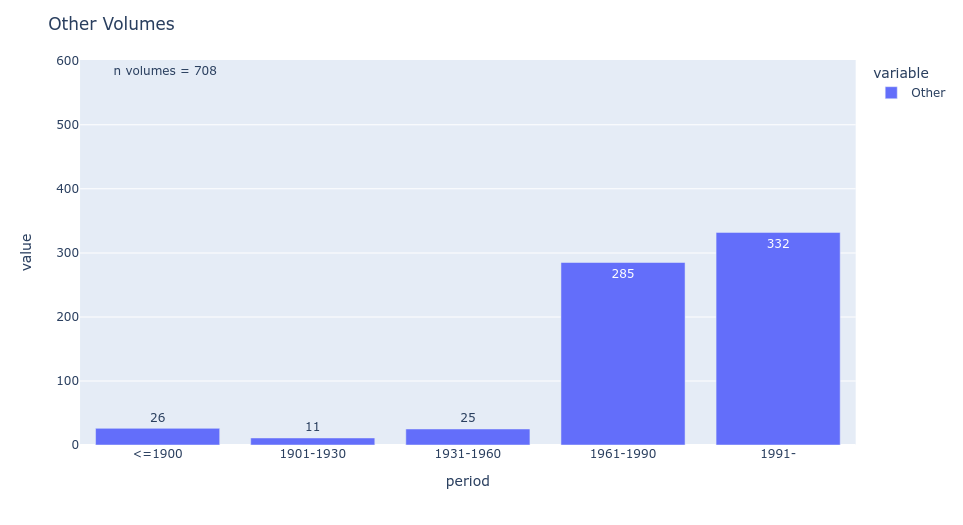

In [47]:
vols_ger_oth = subcorp_vols(ger_marcs_dict["oth"], valid_ger_full)
vols_fren_oth = subcorp_vols(fren_marcs_dict["oth"], valid_fren_full)
vols_eng_oth = subcorp_vols(eng_marcs_dict["oth"], valid_eng_full)

oth_pd = pd.concat([vols_ger_oth, vols_fren_oth, vols_eng_oth])
#oth_pd = oth_pd[oth_pd["pubyear"] != "n.d."]
oth_pd["year"] = oth_pd["marc_008"].str[7:11].astype(int)
plot_oth = plot_corpus(oth_pd, "Other")
n_books = len(oth_pd)
plot_oth.add_annotation(x=0.05, y=570,
            text=f"n volumes = {n_books}",
            showarrow=False,
            yshift=10)
plot_oth.update_layout(title={
        'text': "Other Volumes"})
# Uncomment this line if you run the notebook
# display(plot_oth)

# Comment this line if you run the notebook
Image("figures/vols_oth.png")

In [44]:
vols_ger_oth.to_csv("output/csv/vols_ger_oth.csv")
vols_fren_oth.to_csv("output/csv/vols_fren_oth.csv")
vols_eng_oth.to_csv("output/csv/vols_eng_oth.csv")